In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import delayed
import bottleneck as bn
import seaborn as sns
import glob
from time import time
sns.set(style='ticks',font_scale=1.3,context='talk',color_codes=True)

In [10]:
# read grid
path = './output_2013asiri_07/'
zgrid = pd.read_csv(path+'zgrid.out', skipinitialspace=True, sep=' ', header=None)[1][1:51].astype(float)
ds = xr.open_dataset(path+'full_00000.cdf')
dz,dy,dx = np.meshgrid(np.diff(zgrid), np.diff(ds.y*1000),np.diff(ds.x*1000), indexing='ij')
jac =  dy*dx*dz

In [11]:
@delayed
def kinetic_energy(ds):
    '''subsampled kinetic energy'''
    return np.sum ( (jac[::2,::2,::2]/3)*(ds.u[1::2,1::2,1::2]**2+ds.v[1::2,1::2,1::2]**2+(ds.w[1::2,1::2,1::2]*1e-3)**2))

def ts_to_days(timestep,sec_per_timestep=288):
    return timestep*sec_per_timestep/86400

def find_mld_1d(dataflat,zgrid):
    sortind = dataflat.argsort()
    datasorted=dataflat[sortind]
    zgrid = zgrid[sortind]
    return np.interp(dataflat[-7]+0.03,datasorted,zgrid)

def ts_to_days(timestep,sec_per_timestep=288):
    return timestep*sec_per_timestep/86400

@delayed
def find_mld(ds):
    mld=[]
    for i in range(0,len(ds.x),10): # subsampling
        for j in range(0,len(ds.y),10):
            mld.append( find_mld_1d(ds.rho[:,j,i].values.flatten()-1000,zgrid))
    #mldmode,_ = sstats.mode(mld,)
    return bn.nanmedian(mld)

In [13]:
# workflow to lazily compute KE
#start = time()
end = np.int( glob.glob('./output_2013asiri_07/full_*.cdf')[-1][-9:-4] )
template = './output_2013asiri_07/full_{:05d}.cdf'
filenames = (template.format(k) for k in range(0,end,600))
datasets = (xr.open_dataset(fname) for fname in filenames)
ketotals = [kinetic_energy(ds) for ds in datasets]
ke = [item.compute() for item in ketotals]
# analysis part
filenames = (template.format(k) for k in range(0,end,600))
datasets = (xr.open_dataset(fname) for fname in filenames)
mldtotals = [find_mld(ds) for ds in datasets]
mld = [item.compute() for item in mldtotals]
# joining part

ke = np.array( ke )
mld = np.array( mld ) 
#print((time()-start)/60)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


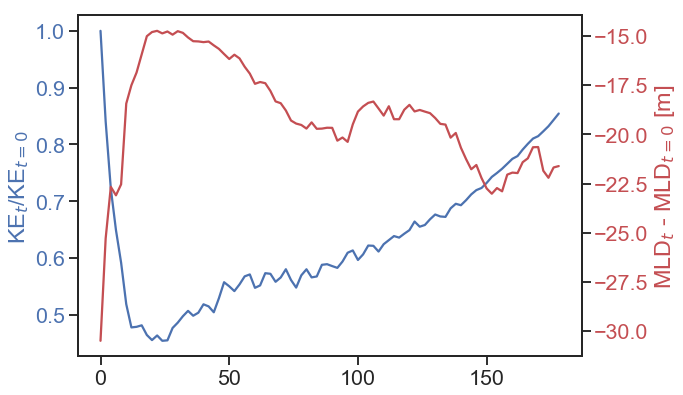

In [19]:
f,(ax1) = plt.subplots(1,1,figsize=(10,6))

ax1.plot(ts_to_days(np.arange(0,end,600)),ke/ke[0],color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel(r'KE$_t$/KE$_{t=0}$', color='b')

ax2 = ax1.twinx()
ax2.plot(ts_to_days(np.arange(0,end,600)),mld,color='r')
ax2.set_ylabel(r'MLD$_t$ - MLD$_{t=0}$ [m]', color='r')
ax2.set_xlabel('time [days]')
ax2.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
plt.savefig('mld_ke_timeseries.pdf',bb_inches='tight')
plt.show()

In [16]:
df = pd.DataFrame(data={'mld':mld,'ke':ke},index=ts_to_days(np.arange(0,end,600)))
df.ken = df.ke/df.ke[0]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


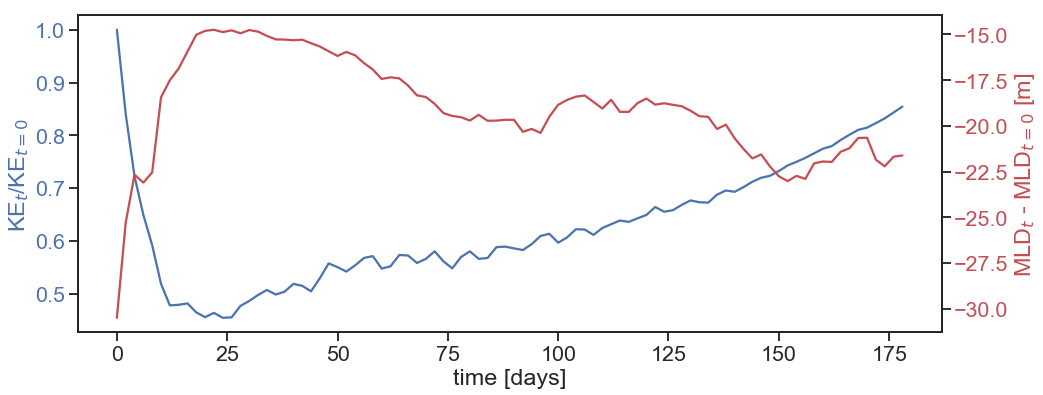

In [17]:
plt.figure(figsize=(15,6))
ax1 =  df.ken.plot(color='b')

ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel(r'KE$_t$/KE$_{t=0}$', color='b')
ax2 = df.mld.plot(secondary_y=True,color='r', ax=ax1)

ax2.set_ylabel(r'MLD$_t$ - MLD$_{t=0}$ [m]', color='r')

ax2.tick_params(axis='y', labelcolor='r')

ax1.set_xlabel('time [days]')

plt.tight_layout()
plt.savefig('ke_and_mld_timeseries.pdf',bb_inches='tight')
plt.show()